# Opertura d'una nova oficina i predicció de potencials localitzacions futures
 

|   INTEGRANTS                    | Arnau Muñoz Barrera     | Míriam López Sánchez       | Luis Martínez Zamora       | Marc Rodríguez Vitolo
| -------------------------- | ----------------------- | -------------------------- | -------------------------- | --------------------------

### 1. Objectius

L'objectiu d'aquest projecte es centra en buscar ubicacions idònies per obrir noves oficines de la Caixa d'Enginyers, valorant tant la possiblitat d'oficines fixes com oficinse mòbils que arriben a una determinada zona. A més, es desenvoluparà també un model predictiu amb l'ajuda d'IA que permeti identificar potencials localitzacions futures.

### 2. Font de les dades

Com a dades per analitzar en aquest projecte s'han agafat conjunts de dades extrets de fonts oficials: INE, BdE, Generalitat de Catalunya i propis de Caixa d'Enginyers.

### 3. Metodologia seguida

- Recerca de dades
- Anàlisi de dades amb python (realització de gràfiques i extracció d'estadístiques)
- Interpretació de resultats
- Elecció de les millors ubicacions posibles
- Entrenament del model predictiu
- Test del model predictiu
- Extracció de conclusions


### 4. Anàlisi de les dades

Com a primer pas, caldrà que importar totes les llibreries i utilitats que es faran servir en el desenvolupament del projecte:


In [19]:
%pip install pandas seaborn scikit-learn category_encoders scikit-optimize scipy openpyxl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import gist_heat_r
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm

import warnings
warnings.simplefilter(action='ignore')

Note: you may need to restart the kernel to use updated packages.


A continuació, es farà la importació dels datasets (arxius d'extensió **.xlsx**) a analitzar i s'analitzaran breument:

Estructura Interna de dataframe_bancs_per_provincia:  (53, 5)
     Columna1          Columna2            Columna3                Columna4  \
0  Provincia   Banco de España   Oficinas en España  Entidades de depósito    
1       Álava               NaN                 147                     147   
2    Albacete               NaN                 211                     211   
3     Alacant                 1                 603                     601   
4     Almería               NaN                 286                     285   

                            Columna5  
0  Otras entidades de crédito y EFC   
1                                NaN  
2                                NaN  
3                                  2  
4                                  1  


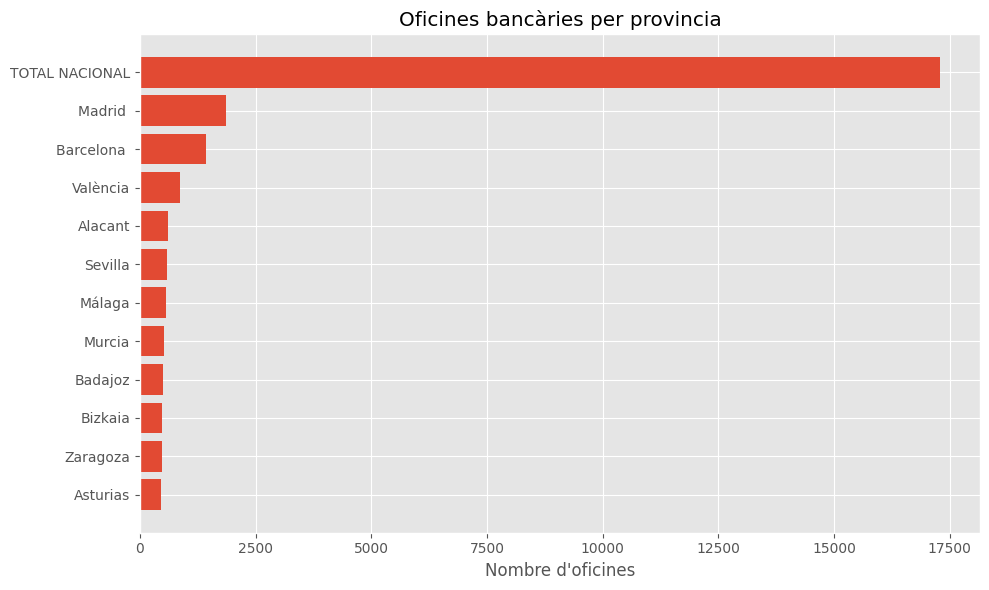

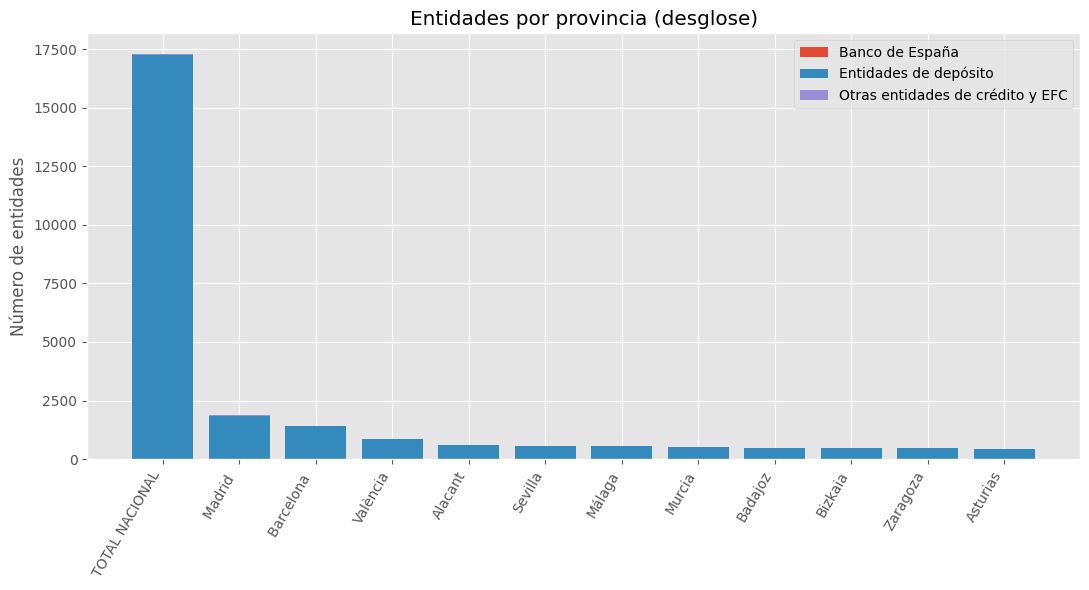

In [20]:
dataframe_bancs_per_provincia = pd.read_excel('data/Bancs per provincia.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_bancs_per_provincia: ", dataframe_bancs_per_provincia.shape)

print(dataframe_bancs_per_provincia.head(5))

dfb = dataframe_bancs_per_provincia.copy()

if any(str(c).lower().startswith('columna') for c in dfb.columns):
    dfb.columns = dfb.iloc[0].tolist()
    dfb = dfb.iloc[1:].reset_index(drop=True)

dfb.columns = [str(c).strip() for c in dfb.columns]

name_col = 'Provincia'
cols_val = [
    'Banco de España',
    'Oficinas en España',
    'Entidades de depósito',
    'Otras entidades de crédito y EFC'
]

for c in cols_val:
    if c in dfb.columns:
        dfb[c] = pd.to_numeric(dfb[c], errors='coerce').fillna(0)

posibles_sel = ['Seleccion','Selección','SELECCION','SELECCIÓN','Plot','PLOT','Marcar','Include','Selected']
sel_col = next((c for c in dfb.columns if str(c).strip() in posibles_sel), None)

if sel_col is not None:
    def _to_bool(v):
        s = str(v).strip().lower()
        return (v is True) or (s in ('1','si','sí','true','x','y','yes'))
    dfb_plot = dfb[dfb[sel_col].apply(_to_bool)].copy()
else:
    if 'Oficinas en España' in dfb.columns:
        dfb_plot = dfb.sort_values('Oficinas en España', ascending=False).head(12).copy()
    else:
        dfb_plot = dfb.copy()

if 'Oficinas en España' in dfb_plot.columns:
    plt.figure(figsize=(10,6))
    plt.barh(dfb_plot[name_col], dfb_plot['Oficinas en España'])
    plt.gca().invert_yaxis()
    plt.title('Oficines bancàries per provincia')
    plt.xlabel("Nombre d'oficines")
    plt.tight_layout()
    plt.show()

presentes = [c for c in ['Banco de España','Entidades de depósito','Otras entidades de crédito y EFC'] if c in dfb_plot.columns]
if presentes:
    plt.figure(figsize=(11,6))
    bottom = np.zeros(len(dfb_plot))
    for c in presentes:
        plt.bar(dfb_plot[name_col], dfb_plot[c], bottom=bottom, label=c)
        bottom += dfb_plot[c].values
    plt.xticks(rotation=60, ha='right')
    plt.title('Entidades por provincia (desglose)')
    plt.ylabel('Número de entidades')
    plt.legend()
    plt.tight_layout()
    plt.show()

##### Punts clau
Arreu del territori espanyol es troben distribuïdes més de 17 000 oficines bancàries, sumant les de les diferents entitats que operen al país. Es pot veure que les tres provincies amb més volum d'oficines són Madrid, Barcelona i València.

Estructura Interna de dataframe_empresa_per_mida_and_provincia:  (72, 31)
   Unnamed: 0       CCAA Provincias  2009 Total      2009  2010 Total  \
0         NaN  Andalucía    Almería       42535  0.085366       41548   
1         NaN  Andalucía      Cádiz       61021  0.122467       60125   
2         NaN  Andalucía    Córdoba       48222  0.096780       47422   
3         NaN  Andalucía    Granada       58317  0.117040       57618   
4         NaN  Andalucía     Huelva       26263  0.052709       25795   

       2010  2011 Total      2011  2012 Total  ...  2018 Total      2018  \
0  0.084446       40995  0.085065       40516  ...       43406  0.083709   
1  0.122204       58960  0.122342       57288  ...       61786  0.119156   
2  0.096385       46553  0.096598       45278  ...       47874  0.092326   
3  0.117109       56209  0.116634       55183  ...       60020  0.115750   
4  0.052428       24981  0.051836       24168  ...       25236  0.048668   

   2019 Total      2019  2020 

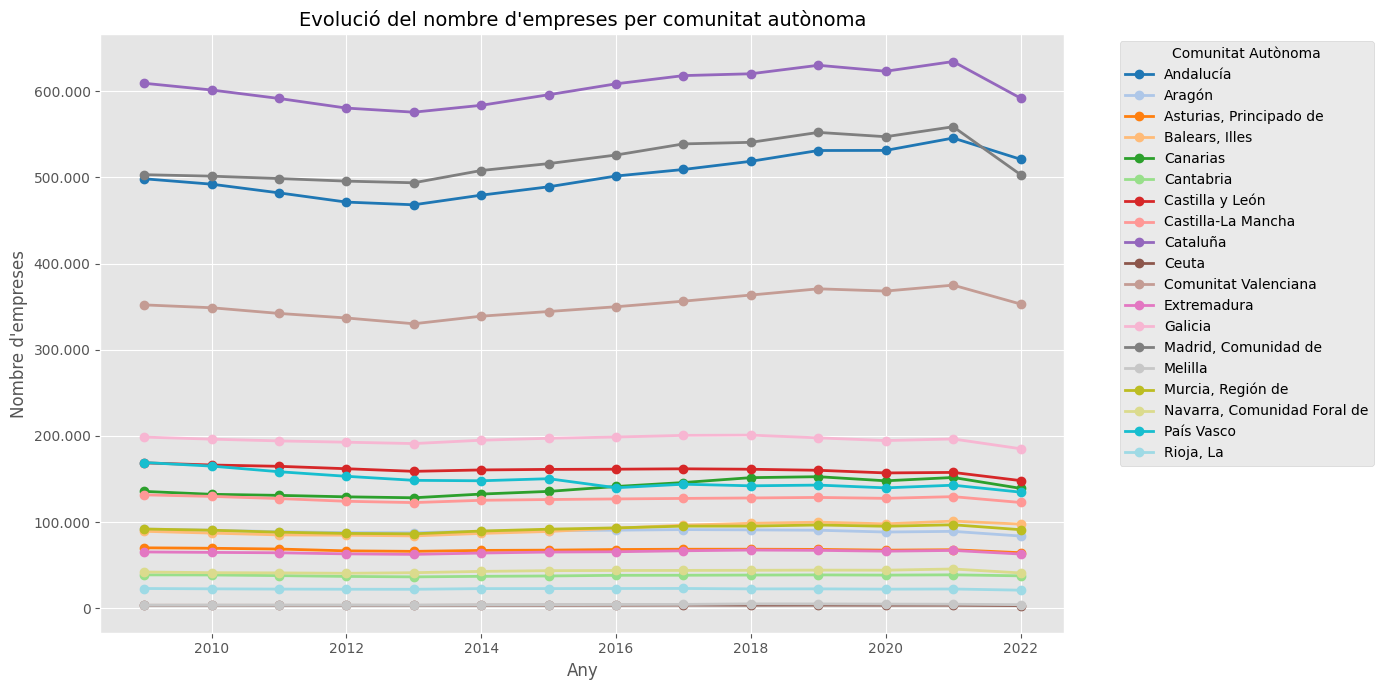

In [21]:
dataframe_empresa_per_mida_and_provincia = pd.read_excel('data/Empresa per mida y provincia 2008-2022.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_empresa_per_mida_and_provincia: ", dataframe_empresa_per_mida_and_provincia.shape)

print(dataframe_empresa_per_mida_and_provincia.head(5))

df = dataframe_empresa_per_mida_and_provincia.copy()

prov_col = 'Provincias' if 'Provincias' in df.columns else 'Provincia'

df = df[
    (df['CCAA'].str.strip().str.lower() != 'total') &      
    (df[prov_col].astype(str).str.strip().str.lower() == 'total')
]

columnas_total = [col for col in df.columns if ('Total' in col and col.split()[0].isdigit())]
columnas_total = sorted(columnas_total, key=lambda c: int(c.split()[0]))

df_grouped = df.groupby('CCAA', as_index=False)[columnas_total].sum()

plt.figure(figsize=(14, 7))

comunidades = df_grouped['CCAA'].values
num_comunidades = len(comunidades)
colors = cm.get_cmap('tab20', num_comunidades)

años = [int(col.split()[0]) for col in columnas_total]

for i, row in df_grouped.iterrows():
    comunidad = row['CCAA']
    valores = row[columnas_total].values.astype(float)
    plt.plot(años, valores, marker='o', color=colors(i), label=comunidad, linewidth=2)

plt.xlabel('Any', fontsize=12)
plt.ylabel("Nombre d'empreses", fontsize=12)
plt.title("Evolució del nombre d'empreses per comunitat autònoma", fontsize=14)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))
plt.legend(title='Comunitat Autònoma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Punts clau
Es pot observar en el gràfic que la comunitat autònoma amb més empreses és Catalunya, seguida de prop per Andalucía i Madrid. Es pot destacar també la quantitat d'empreses situades a la Comunitat Valenciana.

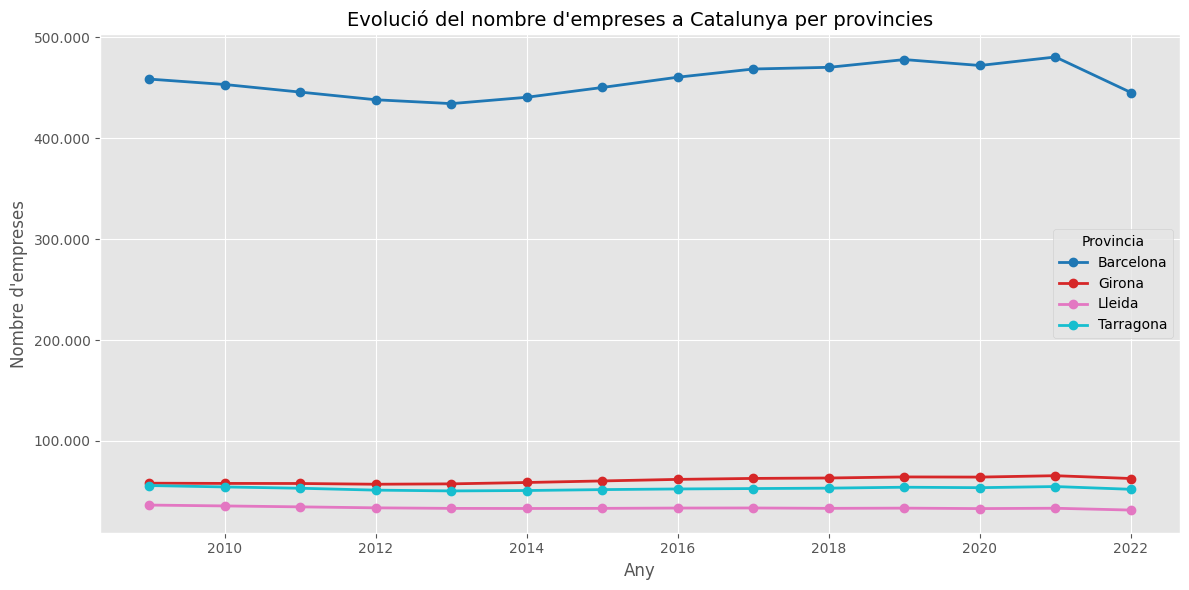

In [22]:
df = dataframe_empresa_per_mida_and_provincia.copy()

prov_col = 'Provincias' if 'Provincias' in df.columns else 'Provincia'

provincias_catalunya = ['Barcelona', 'Girona', 'Lleida', 'Tarragona']
df_cat = df[df[prov_col].isin(provincias_catalunya)]

columnas_total = [col for col in df_cat.columns if ('Total' in col and col.split()[0].isdigit())]
columnas_total = sorted(columnas_total, key=lambda c: int(c.split()[0]))
años = [int(col.split()[0]) for col in columnas_total]

plt.figure(figsize=(12, 6))

colors = cm.get_cmap('tab10', len(provincias_catalunya))

for i, prov in enumerate(provincias_catalunya):
    datos_prov = df_cat[df_cat[prov_col] == prov]
    valores = datos_prov[columnas_total].values.flatten().astype(float)
    plt.plot(años, valores, marker='o', linewidth=2, color=colors(i), label=prov)

plt.xlabel('Any', fontsize=12)
plt.ylabel("Nombre d'empreses", fontsize=12)
plt.title("Evolució del nombre d'empreses a Catalunya per provincies", fontsize=14)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))

plt.legend(title='Provincia')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Punts claus
Tal i com es podria suposar, la provincia de Barcelona té la major concentració d'empreses, trobant-se al voltant de 450 000. Les altres tres provincies queden notablement per sota de les 100 000.

Estructura Interna de dataframe_variacio_PIB_per_capita:  (62, 16)
         AÑO      TIPUS   2009   2010   2011   2012   2013   2014   2015  \
0  ANDALUCÍA       CCAA  17685  17567  17299  16597  16381  16600  17458   
1    Almería  PROVINCIA  19151  18616  17294  17031  16759  17515  18724   
2      Cádiz  PROVINCIA  16899  17054  16881  16196  15843  15703  16255   
3    Córdoba  PROVINCIA  16816  16641  16403  15479  15710  15846  16862   
4    Granada  PROVINCIA  16639  16431  16347  15971  15877  16429  17320   

    2016   2017   2018   2019   2020   2021   2022  
0  17865  18691  19291  19744  17772  19591  21532  
1  20196  21467  21567  22268  20335  20292  22078  
2  16784  17584  18079  18767  16418  18313  20520  
3  17197  17967  18275  18225  16851  18710  20022  
4  17368  17846  18353  19091  17310  18776  20623  


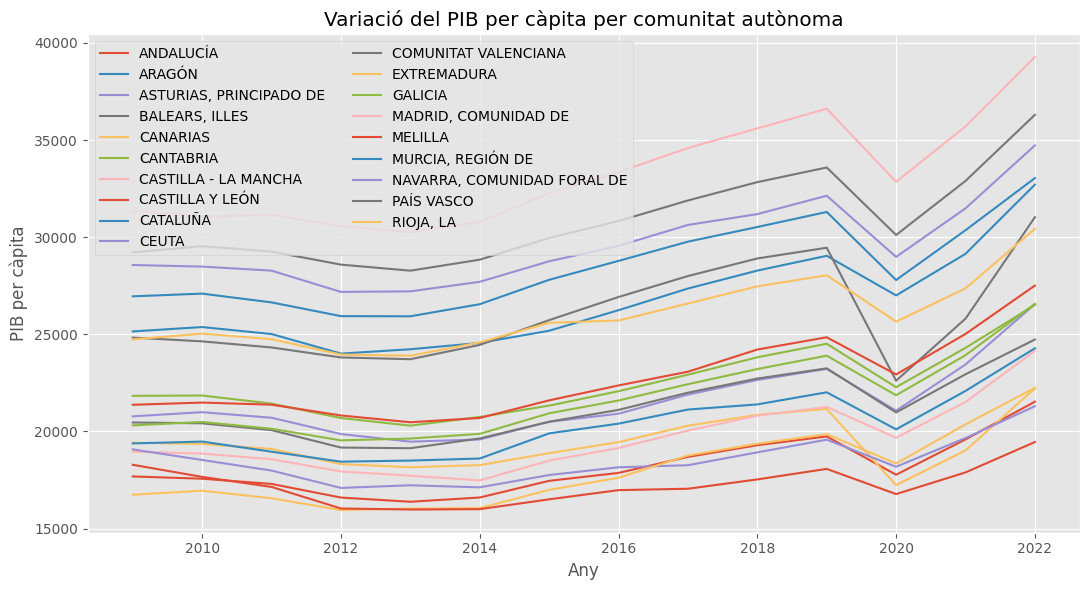

In [23]:
dataframe_variacio_PIB_per_capita = pd.read_excel('data/Variació PIB per capita.xlsx', sheet_name=0, header=0, engine='openpyxl')
print("Estructura Interna de dataframe_variacio_PIB_per_capita: ", dataframe_variacio_PIB_per_capita.shape)

print(dataframe_variacio_PIB_per_capita.head(5))

df = dataframe_variacio_PIB_per_capita.copy()

year_cols = [c for c in df.columns
             if str(c).isdigit() and len(str(c)) == 4 and 2000 <= int(c) <= 2099]

name_col = df.columns[0]
type_col = df.columns[1]

posibles_sel = [
    'Plot','PLOT','Selección','SELECCIÓN','Seleccion','SELECCION',
    'Marcar','MARCAR','Include','INCLUDE','Selected','SELECTED',
    'Graficar','GRAFICAR','Mostrar','MOSTRAR'
]
sel_col = next((c for c in df.columns if str(c).strip() in posibles_sel), None)

ccaa = df[df[type_col].astype(str).str.upper().str.contains('CCAA')].copy()

excluir = {'ESPAÑA', 'TOTAL', 'TOTAL NACIONAL'}
ccaa = ccaa[~ccaa[name_col].astype(str).str.upper().isin(excluir)]

if sel_col is not None:
    def _to_bool(v):
        s = str(v).strip().lower()
        return (v is True) or (s in ('1','si','sí','true','x','y','yes'))
    ccaa = ccaa[ccaa[sel_col].apply(_to_bool)]

melted = ccaa.melt(
    id_vars=[name_col, type_col],
    value_vars=year_cols,
    var_name='Año',
    value_name='PIB_per_capita'
)
melted['Año'] = melted['Año'].astype(int)

plt.figure(figsize=(11,6))
for region, sub in melted.groupby(name_col):
    plt.plot(sub['Año'], sub['PIB_per_capita'], label=region)

plt.title('Variació del PIB per càpita per comunitat autònoma')
plt.xlabel('Any')
plt.ylabel('PIB per càpita')
plt.legend(loc='best', ncol=2)
plt.tight_layout()
plt.show()



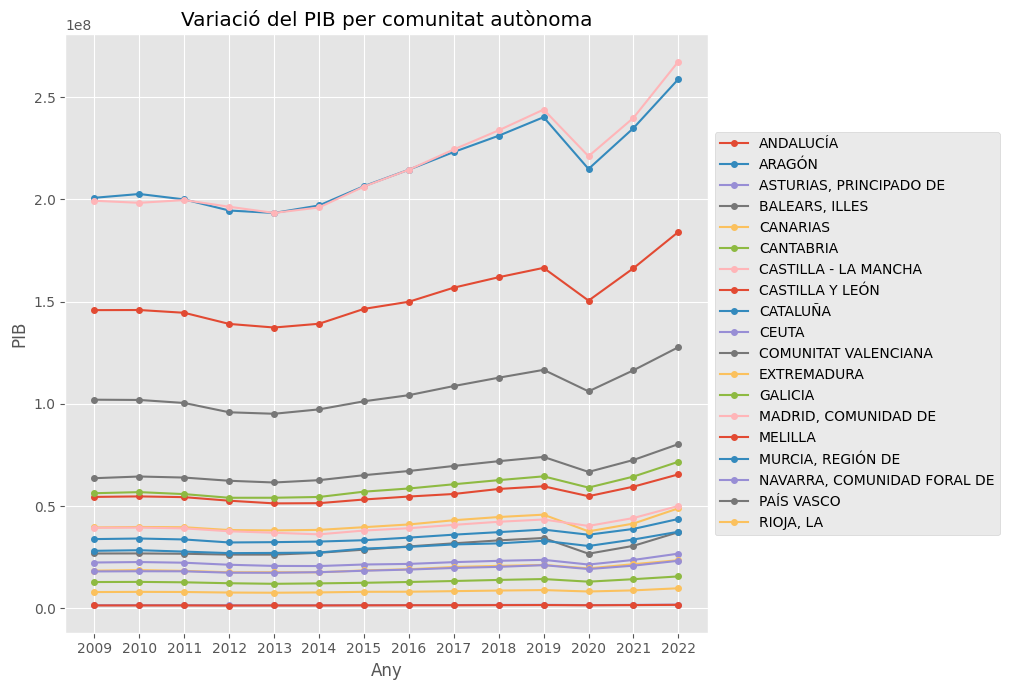

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Cargar datos ---
df2 = pd.read_excel('data/Variació PIB.xlsx', sheet_name=0)

# --- Detectar columnas de años ---
year_cols = [
    c for c in df2.columns
    if str(c).isdigit() and len(str(c)) == 4 and 2000 <= int(c) <= 2099
]

name_col = df2.columns[0]
type_col = df2.columns[1]

# --- Filtrar CCAA ---
ccaa2 = df2[df2[type_col].astype(str).str.upper().str.contains('CCAA')].copy()
ccaa2 = ccaa2[~ccaa2[name_col].astype(str).str.upper().isin({'ESPAÑA', 'TOTAL', 'TOTAL NACIONAL'})]

# --- Si hay columna de selección ---
posibles_sel = ['Plot','PLOT','Selección','SELECCIÓN','Seleccion','SELECCION','Marcar','MARCAR',
                'Include','INCLUDE','Selected','SELECTED','Graficar','GRAFICAR','Mostrar','MOSTRAR']

sel_col = next((c for c in df2.columns if str(c).strip() in posibles_sel), None)

if sel_col is not None:
    def _to_bool(v):
        s = str(v).strip().lower()
        return (v is True) or (s in ('1','si','sí','true','x','y','yes'))
    ccaa2 = ccaa2[ccaa2[sel_col].apply(_to_bool)]

# --- Reorganizar ---
melted2 = ccaa2.melt(
    id_vars=[name_col, type_col],
    value_vars=year_cols,
    var_name='Año',
    value_name='PIB'
)

melted2['Año'] = melted2['Año'].astype(int)
melted2['PIB'] = pd.to_numeric(melted2['PIB'], errors='coerce')

# --- Gráfico con la misma estética que el anterior ---
fig, ax = plt.subplots(figsize=(12, 7))

for region, sub in melted2.groupby(name_col):
    ax.plot(sub['Año'], sub['PIB'], marker='o', markersize=4, label=region)

# X solo con enteros
ax.set_xticks(sorted(melted2['Año'].unique()))
ax.set_xticklabels(sorted(melted2['Año'].unique()))

ax.set_title('Variació del PIB per comunitat autònoma')
ax.set_xlabel('Any')
ax.set_ylabel('PIB')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


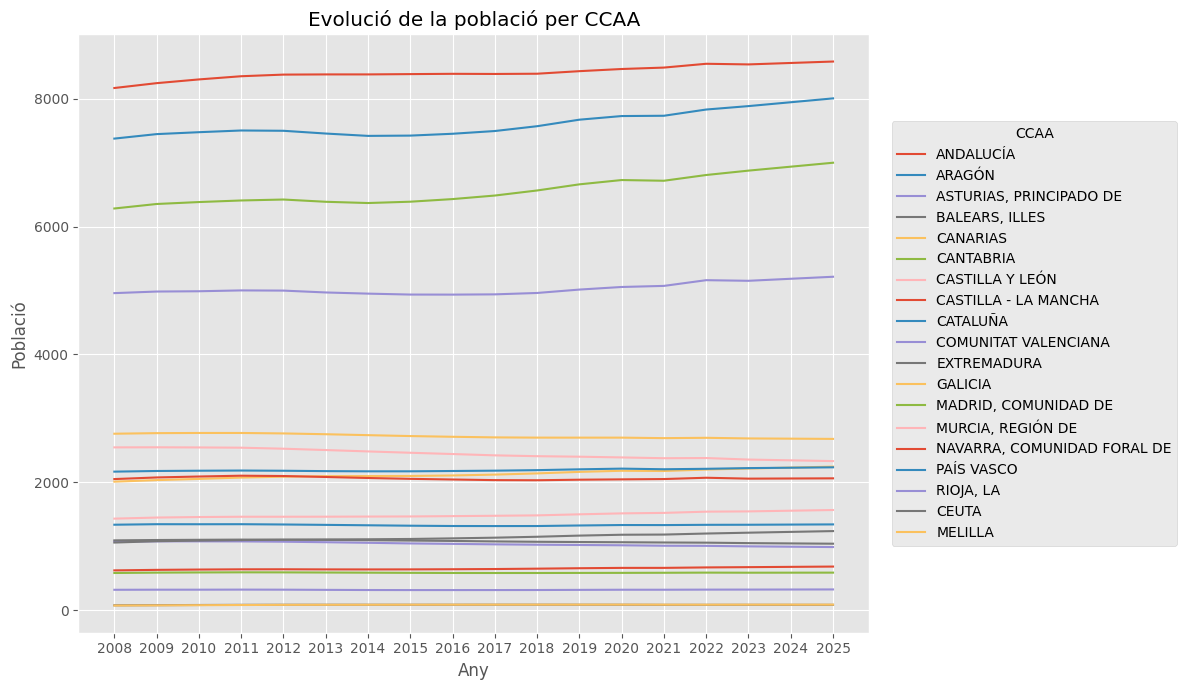

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('data/habitantes.xlsx')

df_ccaa = df[df['TIPO'] == 'CCAA'].copy()

df_ccaa['CCAA'] = df_ccaa['CCAA'].str.strip()
df_ccaa = df_ccaa.set_index('CCAA').drop('TIPO', axis=1)

df_plot = df_ccaa.T
df_plot.index = df_plot.index.astype(int)

# Graficar
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_plot)

ax.set_xticks(df_plot.index)
ax.set_xticklabels(df_plot.index.astype(str))

ax.set_title('Evolució de la població per CCAA')
ax.set_xlabel('Any')
ax.set_ylabel('Població')

ax.legend(
    df_plot.columns,
    title="CCAA",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


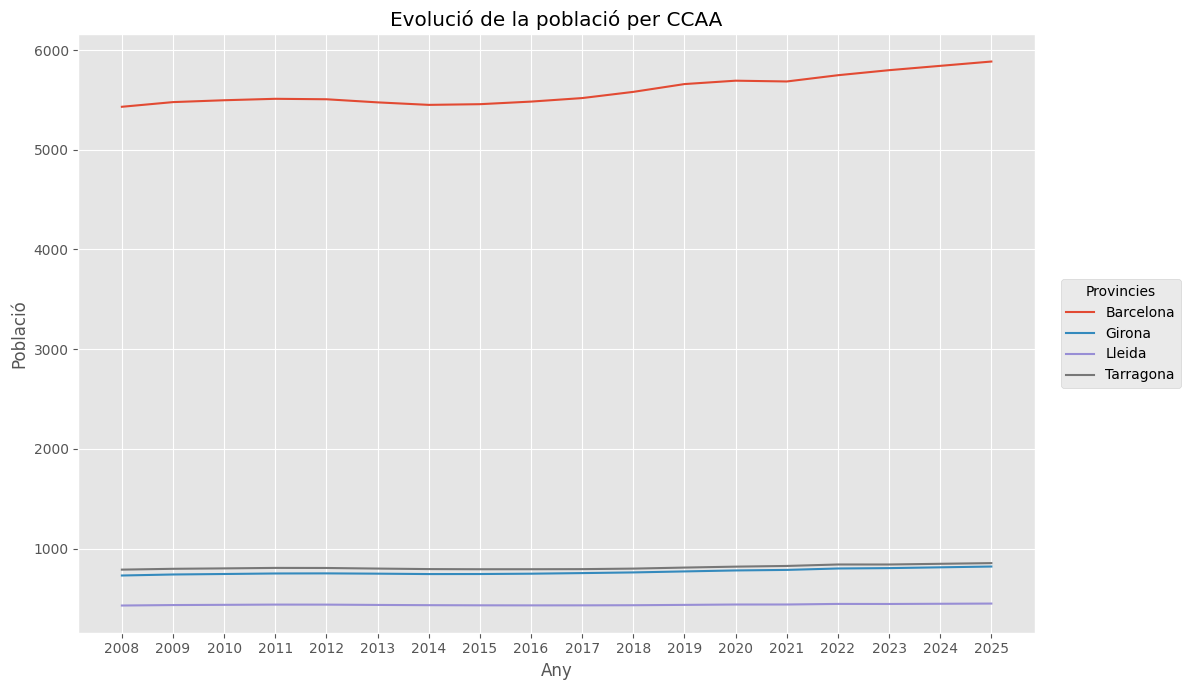

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('data/habitantes.xlsx')

df_ccaa = df[df['TIPO'] == 'PROVINCIA CATALUNYA'].copy()

df_ccaa['CCAA'] = df_ccaa['CCAA'].str.strip()
df_ccaa = df_ccaa.set_index('CCAA').drop('TIPO', axis=1)

df_plot = df_ccaa.T
df_plot.index = df_plot.index.astype(int)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df_plot)

ax.set_xticks(df_plot.index)
ax.set_xticklabels(df_plot.index.astype(str))

ax.set_title('Evolució de la població per CCAA')
ax.set_xlabel('Any')
ax.set_ylabel('Població')

ax.legend(
    df_plot.columns,
    title="Provincies",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


##### Punts clau
De les dades del PIB, la informació que s'extreu no és tant significativa, ja que en totes les provincies evoluciona de manera similar. Es pot destacar, però, que Catalunya es troba en la quarta posició del PIB per càpita més elevat d'Espanya.

### 5. Conclusions anàlisi de dades

Donats els gràfics i les sèries disponibles sobre factors clau a Espanya —com ara el PIB i el creixement de la població, que mostren una distribució desigual—, es conclou que el focus d’anàlisi amb més potencial es troba a Catalunya. Es tracta d’una de les zones més poblades, amb dinàmica de creixement i una elevada concentració d’entitats rellevants per al PIB.

A més, segons dades internes de la Caixa d'Enginyers, la distribució de socis per regió és la següent:

**⚠️ WARNING:** Distribució ficticia de socis per regions (Temporal)

| Regions              | Socis | % sobre total | Variació interanual | Nota breu                                         |
|---------------------------------|-------:|--------------:|---------------------:|----------------------------------------------------|
| Àrea Metropolitana de Barcelona | 72.000 | 60,0%         | +3,2%                | Alta concentració urbana i hubs tecnològics      |
| Comarques Gironines            | 12.600 | 10,5%         | +4,1%                | Creixement en renovables i turisme de qualitat     |
| Camp de Tarragona              | 10.800 | 9,0%          | +3,7%                | Indústria química i logística portuaria            |
| Penedès                        | 8.400  | 7,0%          | +3,5%                | Agroalimentari i teixit exportador                |
| Comarques Centrals             | 7.200  | 6,0%          | +2,8%                | Pymes industrials diversificades                  |
| Ponent                         | 4.800  | 4,0%          | +2,4%                | Agroindústria i energia                            |
| Terres de l’Ebre               | 2.400  | 2,0%          | +2,0%                | Transició energètica i serveis                  |
| Alt Pirineu i Aran             | 1.800  | 1,5%          | +1,7%                | Turisme sostenible i economia de montanya           |
| **Total**                      | **120.000** | **100%**   | —                    | —                                                  |

### 6. Generació de dades amb LLM
Com que algunes de les dades extretes de font oficials no tenen informació dels útlims anys, s'ha optat per útilitzar l'eina Aina per generar dades corresponents a aquests. S'adjunta un exemple de com s'ha fet servir. Les dades generades han estat el nombre d'empreses per comunitat autònoma i la població per provincies i comunitat autònoma entre els anys 2023 i 2025.

![Example](assets/Eina_AINA.jpeg)

### 7. Propostes
#### 7.1 Proposta Nivell Bàsic
Pel nivell bàsic, després de valorar entre diverses opcions, s'ha decidit plantejar la implementació d'una oficina mòbil i proposar-ne la ruta òptima. Per fer-ho, s'ha dissenyat un algoritme que crea un grafo. !!!!!!!!!!!!!!!!!!!

#### 7.2 Proposta Nivell Avançat

### 8. Justificació operativa
Un dels reptes d'aques projecte es que la opertura de les noves oficines puguin estar operatives en menys de 3 mesos. A continuació, s'exposa la justificació de la viabilitat tant per les oficines fixes com pel punt mòbil.

**Oficina fixa**: 
Planificació temporal de l'opetura:
- Mes 1: recerca i lloguer d'un local a la zona triada.
- Mes 2: adequació de l'espai: amoblament, connexions de xarxa a internet, seguretat, etc.
- Mes 3: Formació del personal (en cas que sigui nou), opertura al públic.
Es proposa el lloguer de locals existents i equiparlos amb mobles estil "oficina modular" per fer la mínima obra possible i agilitzar així el procés.

**Oficina Mòbil**
- Es compra un model comercial de furgoneta i es realitza la mínima obra possible: seguretat i connexió segura a la xarxa bancària, intal·lació terminals bancaris.
- Amb l'objectiu de tenir una solució sostenible i compromesa amb els ODS's, es proposa que el vehicle comprat sigui 100% elèctric o híbrid endollable. A més, s'intal·laran panells solars al sostre de la furgoneta que permetin alimentar els equips informàtics. Al pàrquing de l'oficina fixa es posaran punts de recàrrega amb energía renovable — també hi haurà panells solars en els carregadors.

### 9. Justificació econòmica
Un altre punt a tenir en compte és que el projecte proposat tingui una sostenibilitat econòmica. Pel càlcul d'aquesta viabilitat, a més de valorar les dades de costos reals, s'han utilitzat les dades obtingudes del model predictiu per tenir la previsió dels nous socis i poder realitzar càlculs dels ingresos previstos.